<a href="https://colab.research.google.com/github/ElizavetaNosova/Ordering-text-quest-fragments/blob/main/Quest_graph_reconstruction_with_pairwise_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from abc import ABC, abstractmethod, abstractproperty
import networkx as nx
from networkx import json_graph
from sklearn.model_selection import train_test_split
import json
import matplotlib
import math
import itertools
import torch

To evaluate the graph reconstruction we will use a subset of test data, as this task needs more computation when pairwise classification or linear sequence ordering

In [ ]:
ONLINE_GRAPHS_DIRECTORY = 'D:\\Диплом_текстовые_квесты\\Data\\questbook_online_joined_texts'
_, all_test_online_graphs = train_test_split(os.listdir(ONLINE_GRAPHS_DIRECTORY), random_state=42, test_size=0.4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('gdrive/MyDrive')

In [ ]:
COLAB_ONLINE_GRAPHS_DIRECTORY = os.path.join('Quest_data', 'questbook_online_joined_texts')
_, all_test_online_graphs = train_test_split(os.listdir(COLAB_ONLINE_GRAPHS_DIRECTORY), random_state=42, test_size=0.4)

In [ ]:
len(all_test_online_graphs)

72

In [ ]:
_, test_graphs4reconstruction = train_test_split(all_test_online_graphs, random_state=42, test_size=0.2)

In [ ]:
len(test_graphs4reconstruction)

15

In [ ]:
class FullyConnectedGraphConstructor(ABC):
    data_type=str
    
    def __call__(self, quest_graph, data_key='fragment_text'):
        probability_graph = nx.DiGraph()
        
        real_nodes = self._get_real_nodes(quest_graph, data_key)
        for real_node in real_nodes:
            probability_graph.add_node(real_node, output_degree = quest_graph.out_degree(real_node))
            
        preprocessing_result = self._preprocess_graph(quest_graph, real_nodes, data_key)
        for node_from in real_nodes:
            for node_to in real_nodes:
                if node_from != node_to:
                    score = self._calc_score(node_from, node_to, quest_graph, preprocessing_result)
                    probability_graph.add_edge(node_from, node_to, score=score)
        return probability_graph
        
    @abstractmethod
    def _calc_score(self, node1, node2, quest_graph,preprocessing_result=None):
        pass
    
    @abstractmethod
    def _preprocess_graph(self, quest_graph, real_nodes, data_key):
        pass
    
    def _get_real_nodes(self, quest_graph, data_key):
        nodes = quest_graph.nodes()
        return [node for node in nodes if data_key in nodes[node] and isinstance(nodes[node][data_key], self.data_type)]

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
bert_model = BertForNextSentencePrediction.from_pretrained('bert_next_sent_cls')

In [ ]:
class EntityGridGraphConstructor(FullyConnectedGraphConstructor):
    def __init__(self, model, preprocessor, labels):
        self.model = model
        self.preprocessor = preprocessor
        self.labels = labels
        
    def _preprocess_graph(self, quest_graph, real_nodes, data_key):
        nodes = quest_graph.nodes()
        return {node:self.preprocessor.text2nouns(nodes[node][data_key]) for node in real_nodes}
    
    
    def _calc_score(self, node1, node2, quest_graph, preprocessing_result):
        features = self.preprocessor.fragment_pair2transitions(preprocessing_result[node1], preprocessing_result[node2])
        embedding = torch.tensor([self.labels.index(feature) for feature in features])
        return float(torch.squeeze(self.model(embedding)))
       

In [ ]:
class Bert4NSPGraphConstructor(FullyConnectedGraphConstructor):
    def __init__(self, bert, tokenizer):
        self.bert = bert
        self.tokenizer = tokenizer
        self.bert.cuda()
        self.bert.eval()

    def _preprocess_graph(self, quest_graph, real_nodes, data_key):
        nodes = quest_graph.nodes()
        return {node:nodes[node][data_key] for node in real_nodes}
        
    def _calc_score(self, node1, node2, quest_graph, preprocessing_result):
        fragment1 = preprocessing_result[node1]
        fragment2 = preprocessing_result[node2]
        encoding = self.tokenizer(fragment1, fragment2, return_tensors='pt', truncation=True, max_length=512)
        encoding = {key:encoding[key].cuda() for key in encoding}
        outputs = self.bert(**encoding)
        prediction = torch.softmax(outputs.logits, 1)[:, 0]
        return float(prediction)


In [ ]:
class RandomGraphConstructor(FullyConnectedGraphConstructor):
    def _preprocess_graph(self, quest_graph, real_nodes, data_key):
        nodes = quest_graph.nodes()
        return {node:nodes[node][data_key] for node in real_nodes}
        
    def _calc_score(self, node1, node2, quest_graph, preprocessing_result):
        return random.random()


In [ ]:
import torch
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize
morph = MorphAnalyzer()

In [ ]:
class TransitionsNetwork(torch.nn.Module):
    def __init__(self, num_transition_types, embedding_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(num_embeddings=num_transition_types, embedding_dim=embedding_dim)
        self.linear = torch.nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = torch.mean(x, 0)
        x = self.linear(x)
        return torch.sigmoid(x)


fiction_labels = ['SO-SO', 'SO-X', 'X-SO', 'X-X', 'SO-_', '_-SO', 'X-_', '_-X']
entity_grid_model_fiction = torch.load('transitions_model.pth')

class PairPreprocessor(ABC):
    def __init__(self, morphanalyzer):
        self.morphanalyzer = morphanalyzer
        self.subj_obj_tag = 'SO'
        self.other_tag = 'X'
        
        
    def case2tag(self, feature):
        return 'SO' if feature in ['nomn', 'accs', 'gent'] else 'X'
    
    def fragment_pair2transitions(self, fragment1_nouns, fragment2_nouns):
        transitions = []
        for noun, label1 in fragment1_nouns.items():
            label2 = fragment2_nouns[noun] if noun in fragment2_nouns else '_'
            transition = '-'.join([label1, label2])
            transitions.append(transition)
        for noun, label2 in fragment2_nouns.items():
            if noun not in fragment1_nouns:
                transition = '-'.join(['_', label2])
                transitions.append(transition)
        return transitions
    
    @abstractmethod
    def text2nouns(self, text):
        pass
    
class TextPairPreprocessor(PairPreprocessor):
    
    def text2nouns(self, text):
        nouns = {}
        for token in wordpunct_tokenize(text):
            p = self.morphanalyzer.parse(token)[0]
            if 'NOUN' in p.tag:
                lemma = p.normal_form
                if lemma not in nouns or nouns[lemma] == self.other_tag:
                    nouns[lemma] = self.parse2tag(p)
        return nouns

    def parse2tag(self, parse):
        if hasattr(parse.tag, 'case'):
            return self.case2tag(parse.tag.case)


In [ ]:
text_pair_preprocessor_fiction = TextPairPreprocessor(morph)

In [ ]:
fiction_labels

['SO-SO', 'SO-X', 'X-SO', 'X-X', 'SO-_', '_-SO', 'X-_', '_-X']

In [ ]:
fiction_entity_graph_constructor = EntityGridGraphConstructor(entity_grid_model_fiction, text_pair_preprocessor_fiction, fiction_labels)

In [ ]:
PROBABILITIES_DIRECTORY = 'D:\\Диплом_текстовые_квесты\\Binary models graph probabilities'

In [ ]:
method_directory = os.path.join(PROBABILITIES_DIRECTORY, 'Entity_grid_fiction')
method_directory2 = 'Bert4NSPFullyConnectedGraphs'

In [ ]:
try:
    os.mkdir(method_directory2)
    pass
except FileExistsError:
    pass

In [ ]:
bert_graph_reconstructor = Bert4NSPGraphConstructor(bert_model, tokenizer)

In [ ]:
random_graph_reconstructor = RandomGraphConstructor()

In [ ]:
for file in test_graphs4reconstruction:
    with open(os.path.join(ONLINE_GRAPHS_DIRECTORY, file)) as f:
        quest_graph = json_graph.node_link_graph(json.load(f))
    probability_graph = fiction_entity_graph_constructor(quest_graph)
    probability_graph_json = json_graph.node_link_data(probability_graph)
    with open(os.path.join(PROBABILITIES_DIRECTORY, method_directory, file), 'w', encoding='utf-8') as f:
        json.dump(probability_graph_json, f)

In [ ]:
from tqdm import tqdm

In [ ]:
for file in tqdm(test_graphs4reconstruction):
    with open(os.path.join(COLAB_ONLINE_GRAPHS_DIRECTORY, file)) as f:
        quest_graph = json_graph.node_link_graph(json.load(f))
    probability_graph = bert_graph_reconstructor(quest_graph)
    probability_graph_json = json_graph.node_link_data(probability_graph)
    with open(os.path.join(method_directory2, file), 'w', encoding='utf-8') as f:
        json.dump(probability_graph_json, f)



  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:35<08:14, 35.34s/it]

 13%|█▎        | 2/15 [00:40<05:43, 26.41s/it]

 20%|██        | 3/15 [00:57<04:40, 23.41s/it]

 27%|██▋       | 4/15 [01:31<04:52, 26.62s/it]

 33%|███▎      | 5/15 [01:52<04:08, 24.85s/it]

 40%|████      | 6/15 [04:09<08:47, 58.65s/it]

 47%|████▋     | 7/15 [04:17<05:48, 43.55s/it]

 53%|█████▎    | 8/15 [07:35<10:28, 89.80s/it]

 60%|██████    | 9/15 [07:36<06:18, 63.05s/it]

 67%|██████▋   | 10/15 [27:53<34:06, 409.37s/it]

 73%|███████▎  | 11/15 [29:49<21:24, 321.22s/it]

 80%|████████  | 12/15 [30:40<12:00, 240.09s/it]

 87%|████████▋ | 13/15 [31:10<05:54, 177.22s/it]

 93%|█████████▎| 14/15 [32:04<02:20, 140.10s/it]

100%|██████████| 15/15 [32:27<00:00, 129.81s/it]


In [ ]:
import random
#os.mkdir('random_graphs')
for file in test_graphs4reconstruction:
    with open(os.path.join(COLAB_ONLINE_GRAPHS_DIRECTORY, file)) as f:
        quest_graph = json_graph.node_link_graph(json.load(f))
    probability_graph = random_graph_reconstructor(quest_graph)
    probability_graph_json = json_graph.node_link_data(probability_graph)
    with open(os.path.join('random_graphs', file), 'w', encoding='utf-8') as f:
        json.dump(probability_graph_json, f)

Let's illustrate reconstruction alghorithm on random data

In [ ]:
graph = nx.DiGraph()

In [ ]:
for i in range(10):
    degree = i//3
    graph.add_node(i, output_degree=degree)

In [ ]:
import random

In [ ]:
for i in range(10):
    for j in range(10):
        if i != j:
            score = random.random() if graph.nodes()[i]['output_degree'] else 0
            graph.add_edge(i, j, score=score)

In [ ]:
labels={node:graph.nodes()[node]['output_degree'] for node in graph.nodes()}
edge_labels = {edge:round(graph.edges()[edge]['score'],2) for edge in graph.edges()}

{(0, 1): Text(0.17959964103891707, 0.2781064409777336, '0'),
 (0, 2): Text(0.72666081725071, -0.5491390934149218, '0'),
 (0, 3): Text(0.5901927446490479, 0.38762882369623197, '0'),
 (0, 4): Text(0.5251154585454378, -0.2583396376616939, '0'),
 (0, 5): Text(0.8840623769811797, 0.12408021722252194, '0'),
 (0, 6): Text(-0.0012728824276500572, -0.02994584618989017, '0'),
 (0, 7): Text(0.07673031503192318, -0.3476059777878715, '0'),
 (0, 8): Text(0.4667829811843004, 0.07319806025629733, '0'),
 (0, 9): Text(0.3297776075014358, -0.5769523975285517, '0'),
 (1, 0): Text(0.17959964103891707, 0.2781064409777336, '0'),
 (1, 2): Text(-0.038151806649197983, -0.046290299829652215, '0'),
 (1, 3): Text(-0.17461987925086003, 0.8904776172815017, '0'),
 (1, 4): Text(-0.23969716535447005, 0.2445091559235757, '0'),
 (1, 5): Text(0.11924975308127173, 0.6269290108077915, '0'),
 (1, 6): Text(-0.766085506327558, 0.4729029473953794, '0'),
 (1, 7): Text(-0.6880823088679848, 0.1552428157973981, '0'),
 (1, 8): Text(

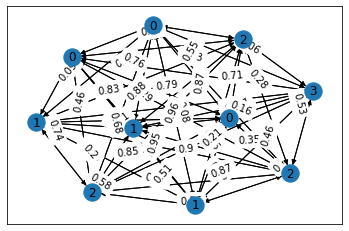

In [ ]:
nx.draw_networkx(graph, labels=labels, pos=nx.spring_layout(graph))
nx.draw_networkx_edge_labels(graph, edge_labels=edge_labels, pos=nx.spring_layout(graph))

In [ ]:
test = nx.algorithms.tree.branchings.maximum_branching(graph, attr='score', preserve_attrs=True)

In [ ]:
node_colors = []
nodes = graph.nodes()
for node in nodes:
    correct_degree = nodes[node]['output_degree']
    current_degree = test.out_degree(node)
    
    if correct_degree > current_degree:
        node_colors.append('green')
    elif correct_degree < current_degree:
        node_colors.append('red')
    else:
        node_colors.append('blue')

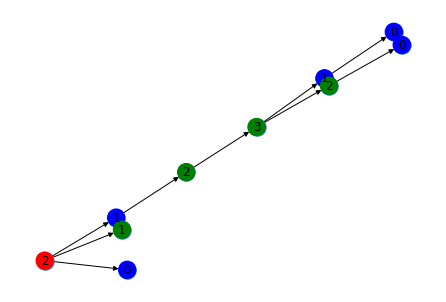

In [ ]:
nx.draw(test, labels=labels, pos=nx.kamada_kawai_layout(test))
nx.draw_networkx_nodes(test, node_color=node_colors, pos=nx.kamada_kawai_layout(test))

In [ ]:
third_step_test = test.copy()

In [ ]:
too_small_degree_nodes = {node:nodes[node]['output_degree']-test.out_degree(node) for node in nodes if nodes[node]['output_degree'] > test.out_degree(node)}
too_large_degree_nodes = {node:test.out_degree(node)-nodes[node]['output_degree'] for node in nodes if nodes[node]['output_degree'] < test.out_degree(node)}

In [ ]:
too_small_degree_nodes

{5: 1, 6: 1, 8: 1, 9: 1}

In [ ]:
too_large_degree_nodes

{7: 1}

In [ ]:
slots = []
for slot_node, num_slots in too_small_degree_nodes.items():
    for i in range(num_slots):
        slots.append(slot_node)

In [ ]:
sorted([4,5,3])

[3, 4, 5]

In [ ]:
third_step_test.edges[(3, 1)]

{'score': 0.8685655494109157}

In [ ]:
list(third_step_test.out_edges(7))

[(7, 4), (7, 5), (7, 0)]

In [ ]:
edges = graph.edges()

nodes_with_removed_input = []
for node in too_large_degree_nodes:
    sorted_node_edges = sorted(list(third_step_test.out_edges(node)), key = lambda edge: edges[edge]['score'])
    edges2remove = sorted_node_edges[:too_large_degree_nodes[node]]
    for node_from, node_to in edges2remove:
        nodes_with_removed_input.append(node_to)
        third_step_test.remove_edge(node_from, node_to)

In [ ]:
itertools

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
nodes_with_removed_input

[5]

In [ ]:
too_small_degree_nodes.items():
    for i in range(num_slots)

dict_items([(5, 1), (6, 1), (8, 1), (9, 1)])

In [ ]:
too_small_degree_nodes

{5: 1, 6: 1, 8: 1, 9: 1}

In [ ]:
best_edge=None
best_edge_score = 0

for node_from in too_small_degree_nodes:
    for node_to in nodes_with_removed_input:
        if node_to != node_from:
            edge = (node_from, node_to)
            score = edges[edge]['score']
            if score > best_edge_score:
                best_edge_score = score
                best_edge = edge

In [ ]:
edge

(9, 5)

In [ ]:
third_step_test.add_edge(9, 5)

In [ ]:
node_colors = []
nodes = graph.nodes()
for node in nodes:
    correct_degree = nodes[node]['output_degree']
    current_degree = third_step_test.out_degree(node)
    
    elif correct_degree > current_degree:
        node_colors.append('green')
    elif correct_degree < current_degree:
        node_colors.append('red')
    else:
        node_colors.append('blue')

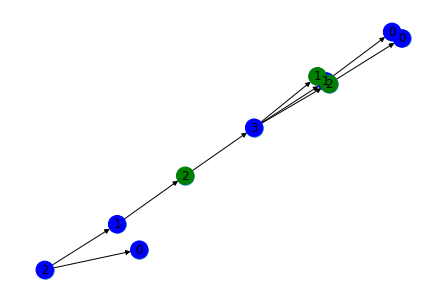

In [ ]:
nx.draw(third_step_test, labels=labels, pos=nx.kamada_kawai_layout(third_step_test))
nx.draw_networkx_nodes(third_step_test, node_color=node_colors, pos=nx.kamada_kawai_layout(third_step_test))

In [ ]:
last_step_test = third_step_test.copy()

In [ ]:
for node in nodes:
    if nodes[node]['output_degree'] > last_step_test.out_degree(node):
        dif = nodes[node]['output_degree'] - last_step_test.out_degree(node)
        extra_edge_candidates = [(node, node2) for node2 in nodes if node2 != node and (node2, node) not in last_step_test.edges()]
        best_edges = sorted(extra_edge_candidates, key = lambda edge: edges[edge]['score'])[:dif]
        for edge in best_edges:
            last_step_test.add_edge(*edge)

In [ ]:
extra_edge_candidates

[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 7)]

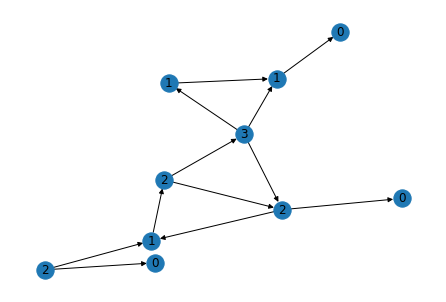

In [ ]:
nx.draw(last_step_test, labels=labels, pos=nx.kamada_kawai_layout(last_step_test))

Reconstruction pipeline

In [ ]:
class StaticLabelsGraphReconstrutor:
    def __init__(self, edge_score_label='score', node_output_degree_label='output_degree', use_ln=True, double_edge_threshold=0.01):
        self.edge_score_label = edge_score_label
        self.node_output_degree_label = node_output_degree_label
        self.use_ln = use_ln
        self.double_edge_threshold = double_edge_threshold
        
    def __call__(self, graph):
        if self.use_ln:
            graph = self._apply_ln(graph)
        
        initial_tree = nx.algorithms.tree.branchings.maximum_branching(graph, attr=self.edge_score_label, preserve_attrs=True)
        step2_tree = self._control_max_output_degree(initial_tree, graph)
        final_solution = self._add_edges(step2_tree, graph)
        return final_solution
        
        
    def _apply_ln(self, graph):
        updated_graph = graph.copy()
        edges = updated_graph.edges()
        updated_attrs = {edge:{self.edge_score_label: math.log(edges[edge][self.edge_score_label])} for edge in edges}
        nx.set_edge_attributes(updated_graph, updated_attrs)
        return updated_graph
    
    
    def _control_max_output_degree(self, tree, fully_connected_graph):
        tree = tree.copy()
        nodes = fully_connected_graph.nodes()
        edges = fully_connected_graph.edges()
        
        too_small_degree_nodes = {node:nodes[node][self.node_output_degree_label]-tree.out_degree(node) for node in nodes if nodes[node][self.node_output_degree_label] > tree.out_degree(node)}
        too_large_degree_nodes = {node:tree.out_degree(node)-nodes[node][self.node_output_degree_label] for node in nodes if nodes[node][self.node_output_degree_label] < tree.out_degree(node)}
        
        if too_large_degree_nodes:
        
            output_slots = []
            for node in too_small_degree_nodes:
                for i in range(too_small_degree_nodes[node]):
                    output_slots.append(node)         
        
            input_slots = []
            for node in too_large_degree_nodes:
                current_node_num_edges_to_remove = too_large_degree_nodes[node]
                current_edges = list(tree.out_edges(node))
                current_edges.sort(key=lambda edge:edges[edge][self.edge_score_label])
                for edge in current_edges[:current_node_num_edges_to_remove]:
                    tree.remove_edge(*edge)
                    input_slots.append(edge[1])
            input_slots = tuple(input_slots)
                
            output_slots_combinations = set([permutation for permutation in itertools.permutations(output_slots, r=len(input_slots))])
            best_combination_score = -math.inf
            best_fully_connected_combination_score = -math.inf
            for output_slots_combination in output_slots_combinations:
                current_combination_score = 0
                for edge_candidate in zip(output_slots_combination, input_slots):
                    current_combination_score += edges[edge_candidate][self.edge_score_label]
                if current_combination_score > best_fully_connected_combination_score and self.__is_combination_fullyconnected(output_slots_combination, input_slots, tree):
                    best_fully_connected_combination_score = current_combination_score
                    best_fully_connected_combination = output_slots_combination
                    
                #if we have found any fully-connected combination, we do not need to update best_combination_score any more
                if best_fully_connected_combination_score == -math.inf and current_combination_score > best_combination_score:
                    best_combination_score = current_combination_score
                    best_combination = output_slots_combination
            if best_fully_connected_combination_score > -math.inf:
                best_combination = best_fully_connected_combination
            for node_from, node_to in zip(best_combination, input_slots):
                tree.add_edge(node_from, node_to)
        return tree
    
    def _add_edges(self, tree, fully_connected_graph):
        tree = tree.copy()
        nodes = fully_connected_graph.nodes()
        edges = fully_connected_graph.edges()
        allow_double_edges = self.__are_double_edges_allowed(fully_connected_graph)
        for node_id in nodes:
            tree_degree = tree.out_degree(node_id)
            target_degree = nodes[node_id][self.node_output_degree_label]
            
            if tree_degree < target_degree:
                new_neighbours_candidates = [candidate for candidate in nodes if candidate != node_id and not tree.has_edge(node_id, candidate) and (not tree.has_edge(candidate, node_id) or allow_double_edges)]
                new_neighbours_candidates.sort(key=lambda candidate: edges[(node_id, candidate)]['score'], reverse=True)
                for candidate in new_neighbours_candidates[:target_degree-tree_degree]:
                    tree.add_edge(node_id, candidate)
        return tree
        
    def __are_double_edges_allowed(self, fully_connected_graph):
        nodes = fully_connected_graph.nodes()
        num_edges = sum([nodes[node_id][self.node_output_degree_label] for node_id in nodes])
        num_possible_edges = len(nodes)*(len(nodes)-1)
        return num_edges/num_possible_edges > self.double_edge_threshold
        
        
    def __is_combination_fully_connected(tree, output_slots, input_slots):
        tree_copy = tree.copy()
        for output_slot, input_slot in zip(output_slots):
            tree_copy.add_edge(output_slot, input_slot)
        return nx.alghorithm.components.number_of_connected_components(tree_copy.to_undirected()) == 1

In [ ]:
def graph_reconstruction_accuracy(predicted_graph, correct_graph):
    predicted_edges = predicted_graph.edges()
    num_correct_edges = sum([correct_graph.has_edge(*predicted_edge) for predicted_edge in predicted_edges])
    return num_correct_edges/len(predicted_edges)

In [ ]:
reconstructor = StaticLabelsGraphReconstrutor()

In [ ]:
accuracy_scores = []
for file in os.listdir(os.path.join(PROBABILITIES_DIRECTORY, method_directory)):
    with open(os.path.join(PROBABILITIES_DIRECTORY, method_directory, file)) as f:
        fully_connected_graph = json_graph.node_link_graph(json.load(f))
    predicted_graph = reconstructor(fully_connected_graph)
    with open(os.path.join(ONLINE_GRAPHS_DIRECTORY, file)) as f:
        correct_graph = json_graph.node_link_graph(json.load(f))
    accuracy_scores.append(graph_reconstruction_accuracy(predicted_graph, correct_graph))

In [ ]:
accuracy_scores = []
for file in os.listdir(os.path.join(method_directory2)):
    with open(os.path.join(method_directory2, file)) as f:
        fully_connected_graph = json_graph.node_link_graph(json.load(f))
    predicted_graph = reconstructor(fully_connected_graph)
    with open(os.path.join(COLAB_ONLINE_GRAPHS_DIRECTORY, file)) as f:
        correct_graph = json_graph.node_link_graph(json.load(f))
    accuracy_scores.append(graph_reconstruction_accuracy(predicted_graph, correct_graph))

In [ ]:
from statistics import mean
mean(accuracy_scores)

0.1847285523525427

In [ ]:
accuracy_scores = []
for file in os.listdir(os.path.join(method_directory2)):
    with open(os.path.join('random_graphs', file)) as f:
        fully_connected_graph = json_graph.node_link_graph(json.load(f))
    predicted_graph = reconstructor(fully_connected_graph)
    with open(os.path.join(COLAB_ONLINE_GRAPHS_DIRECTORY, file)) as f:
        correct_graph = json_graph.node_link_graph(json.load(f))
    accuracy_scores.append(graph_reconstruction_accuracy(predicted_graph, correct_graph))

In [ ]:
mean(accuracy_scores)

0.09096303949931071